In [158]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Numpy seeding 
np.random.seed(2021)

print("imports ok")

imports ok


In [ ]:
"""
Python classification
There are 3 types of input features:
    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.
Features:
    Age | Objective Feature | age | int (days)
    
    Height | Objective Feature | height | int (cm) |
    
    Weight | Objective Feature | weight | float (kg) |
    
    Gender | Objective Feature | gender | categorical code | 1: femme 2: homme |
    
    Systolic blood pressure | Examination Feature | ap_hi | int |
    
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal|
    
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    
    Smoking | Subjective Feature | smoke | binary |
    
    Alcohol intake | Subjective Feature | alco | binary |
    
    Physical activity | Subjective Feature | active | binary |
    
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
    """

In [ ]:
"""
Il s'agit de faire de la classification ici.
on veut faire un modèle capable de prédire si la personne aura des pbs cardio-vasculaires

"""

# importing the CSV with Pandas

In [159]:
# reading the csv :
csv = pd.read_csv(r"./data/cardio_train.csv", error_bad_lines=False, delimiter=";")
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


# checking for missing and duplicated lines 

In [160]:
# checking for missing values :
print("Missing Values : ",csv.isna().values.any()) #should be false

# checking for duplicated lines :
print("Duplicated lines : ", csv.duplicated().values.any()) #should be false

Missing Values :  False
Duplicated lines :  False


# checking for abnormal values

In [161]:
# using describe to check for abnormal values :
csv.describe().round(1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0
mean,49972.4,19468.9,1.3,164.4,74.2,128.8,96.6,1.4,1.2,0.1,0.1,0.8,0.5
std,28851.3,2467.3,0.5,8.2,14.4,154.0,188.5,0.7,0.6,0.3,0.2,0.4,0.5
min,0.0,10798.0,1.0,55.0,10.0,-150.0,-70.0,1.0,1.0,0.0,0.0,0.0,0.0
25%,25006.8,17664.0,1.0,159.0,65.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
50%,50001.5,19703.0,1.0,165.0,72.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
75%,74889.2,21327.0,2.0,170.0,82.0,140.0,90.0,2.0,1.0,0.0,0.0,1.0,1.0
max,99999.0,23713.0,2.0,250.0,200.0,16020.0,11000.0,3.0,3.0,1.0,1.0,1.0,1.0


In [163]:
###########################################################
# age is in days in the dataframe
# checking mean(age) in years by dividing by 365.25:
print("Oldest individual (years):", csv.age.max()/365.25) #ok
print("Youngest individual (years) :", csv.age.min()/365.25) #ok
# age is ok
###############################################################
# the maximum and minimal values of both ap_hi and ap_lo are abherent :
# blood pressure (BP) in humans over 200 is a medical emergency....
# BP >= 180 is called an 'hypertensive crisis'

# BP values over 250 are mesurement errors and should be removed from the dataset :
data = csv[csv.apply(
    lambda x: False if x.ap_hi > 250 or x.ap_lo> 250  else True, axis=1)]

# Negative BP is impossible
# BP values under 30/10 are erroneous as well
# if it goes that low the patient is unconscious/dying
data = data[data.apply(
    lambda x: False if x.ap_hi < 30 or x.ap_lo < 10  else True, axis=1)]

print("Nbr of rows with invalid BP :",  csv.shape[0]-data.shape[0])
###############################################################
# Systolic BP (ap_hi) should also always be > Diastolic BP (ap_lo)
# if it isn't -> mesurement error
# checking if we do have this issue :
print("Nbr of Rows with ap_hi < ap_lo :",
    data[data.apply(lambda x: True if x.ap_hi < x.ap_lo else False, axis=1)].shape[0])
# it appears we do, filtering :
data = data[data.apply(lambda x: False if x.ap_hi < x.ap_lo else True, axis=1)]
###############################################################

print("Total number of row filtered :",  csv.shape[0]-data.shape[0],
     "; Remaining : ", data.shape[0])

Oldest individual (years): 64.92265571526352
Youngest individual (years) : 29.56331279945243
Nbr of rows with invalid BP : 1198
Nbr of Rows with ap_hi < ap_lo : 101
Total number of row filtered : 1299 ; Remaining :  68701


# Feature engineering :

In [164]:
# The dataset contains weight and height data
# (Good news everyone!) We can calculate the BMI for each row with the formula :
# weight(kg)/height(m)^2
#######################################################
data["BMI"] = data.apply(
    lambda x: round(x["weight"]/ ((x["height"]/100)**2),2), axis=1) 
#######################################################
# using .describe() the check the values in the created column
data.BMI.describe()

count    68701.000000
mean        27.521549
std          6.051577
min          3.470000
25%         23.880000
50%         26.350000
75%         30.120000
max        298.670000
Name: BMI, dtype: float64

In [165]:
# BMI max and min values are aberrant
# BMI < 16 : severe famine
# BMI > 40 : morbid obesity
# Counting rows with BMI > 50 or BMI <15:
print("Nbr of row with BMI extremes : ",
     data[data.BMI.map(lambda x: True if x>70 or x<10 else False)].shape[0])

# Filtering morbidly obese dwarves and tall anorexics from the dataset :
data = data[data.BMI.map(lambda x: False if x>70 or x<10 else True)]
print("Remaining rows : ", data.shape[0])
# Checking the remaining values :
data.describe().round(1)

Nbr of row with BMI extremes :  39
Remaining rows :  68662


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0,68662.0
mean,49975.9,19464.4,1.3,164.4,74.1,126.7,81.3,1.4,1.2,0.1,0.1,0.8,0.5,27.5
std,28845.3,2468.1,0.5,8.0,14.3,16.7,9.5,0.7,0.6,0.3,0.2,0.4,0.5,5.3
min,0.0,10798.0,1.0,91.0,28.0,60.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0,10.7
25%,25006.2,17657.2,1.0,159.0,65.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,23.9
50%,50020.5,19701.0,1.0,165.0,72.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,26.4
75%,74868.8,21324.0,2.0,170.0,82.0,140.0,90.0,2.0,1.0,0.0,0.0,1.0,1.0,30.1
max,99999.0,23713.0,2.0,250.0,200.0,240.0,182.0,3.0,3.0,1.0,1.0,1.0,1.0,70.0


In [166]:
# the gender col is encoded with 1 and 2. all the values seem ok
# changing the gender col to be binary :
csv.gender = data.gender.map(lambda x: x-1)
# 0 is now for females and 1 for males
# we'll encode the other categorical variables as binary later!

# Creating a correlation heatmap :

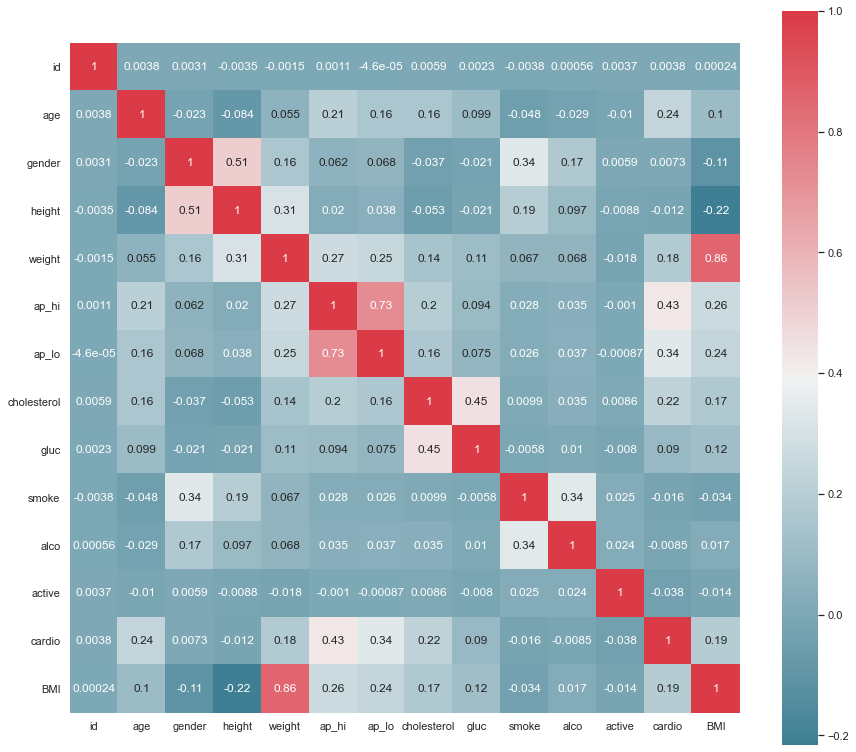

In [167]:
# représentation des corrélations entre les variables en heatmap :

corr = data.corr()
_ , ax = plt.subplots(figsize =( 15 , 15 ))
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr, 
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax, 
    annot = True, 
    annot_kws = { 'fontsize' : 12 }
)

# Splitting categorical variables into binary variables :

In [168]:
# il faut séparer la variable cholestérol en 3 colonnes binaires :
# splitting the cholesterol column into 3 categorical variables:
chol_dummy = pd.get_dummies( data.cholesterol , prefix='Chol')
print(chol_dummy.head())

# splitting the glucose column into 3 categorical variables:
gluc_dummy = pd.get_dummies( data.gluc , prefix='gluc')
print("\n",gluc_dummy.head())

   Chol_1  Chol_2  Chol_3
0       1       0       0
1       0       0       1
2       0       0       1
3       1       0       0
4       1       0       0

    gluc_1  gluc_2  gluc_3
0       1       0       0
1       1       0       0
2       1       0       0
3       1       0       0
4       1       0       0


In [169]:
# assemblage d'une dataframe avec toute les variables pour le training :

#dropping the cols we don't want in the training dataframe : 
data_selected = data.drop(['id','cholesterol', 'gluc',
                       'height', 'weight', 'cardio'], axis=1)
#I chose to drop height and weight since we calculated the BMI

full_df = pd.concat( [ data_selected , chol_dummy, gluc_dummy] , axis=1 )
full_df.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,BMI,Chol_1,Chol_2,Chol_3,gluc_1,gluc_2,gluc_3
0,18393,2,110,80,0,0,1,21.97,1,0,0,1,0,0
1,20228,1,140,90,0,0,1,34.93,0,0,1,1,0,0
2,18857,1,130,70,0,0,0,23.51,0,0,1,1,0,0
3,17623,2,150,100,0,0,1,28.71,1,0,0,1,0,0
4,17474,1,100,60,0,0,0,23.01,1,0,0,1,0,0


# Splitting the dataset :

In [199]:
# Splitting the dataset into 3 subgroups :
# training (70%) ; validation (20%) ; testing(10%)
train_x , valid_x , train_y , valid_y = train_test_split( full_df , data.cardio ,
                                                         train_size = .7, random_state = 2021)

# the following test data will be used to evaluate the final model
# it will NOT be used before
test_x = valid_x.sample(frac = 0.33, random_state = 2021)
test_y = valid_y[test_x.index]
#dropping the lines used in the test dataset from the validation dataset :
valid_x.drop(test_x.index, inplace=True)
valid_y.drop(test_x.index, inplace=True) 

# printing the resulting shapes
print(" Full_df :", full_df.shape,"\n",
      "Training df x :",train_x.shape, "\n",
      "Training df y :",train_y.shape, "\n",
      "Validation df x :",valid_x.shape, "\n",
      "Validation df y :",valid_y.shape, "\n",
      "Test df x :", test_x.shape, "\n",
      "Test df y :", test_y.shape)

 Full_df : (68662, 14) 
 Training df x : (48063, 14) 
 Training df y : (48063,) 
 Validation df x : (13801, 14) 
 Validation df y : (13801,) 
 Test df x : (6798, 14) 
 Test df y : (6798,)


# Plotting  "naive" variable importance :

In [211]:
def plot_variable_importance( X , y ):
    # model tuning is just a guess for now
    # I've selected these hyperparams just to reduce overfitting
    classif = RandomForestClassifier(n_estimators=200,      
                                      min_samples_leaf=5,
                                      max_features=0.5,
                                      n_jobs=-1)
    classif.fit( X , y )
    plot_model_var_imp( classif , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    plt = imp.plot( kind = 'barh', 
             title= 'Variable importance (more is better)',
             color="#DC77F6",
            )

    print (model.score( X , y ))
    
# plot_variable_importance(train_X, train_y)

#### I made the decision to not remove any variables for now.

# Model definition :

In [136]:
# defining every model for comparaison :
# NB: I already tried the random forest classifier
# This is why it is a bit more tuned than the others
rand_for = RandomForestClassifier(n_estimators=200,
                                  max_depth = 7,      
                                  min_samples_leaf=5,
                                  max_features=0.5,
                                  n_jobs=-1)
sup_vec_mach = SVC()
grad_boost = GradientBoostingClassifier()
k_nearest= KNeighborsClassifier(n_neighbors = 3)
gau_naive= GaussianNB()
logi_reg= LogisticRegression()

# Model training :

In [137]:
# training every model :
rand_for.fit( train_X , train_y )
sup_vec_mach.fit( train_X , train_y )
grad_boost.fit( train_X , train_y )
k_nearest.fit( train_X , train_y )
gau_naive.fit( train_X , train_y )
logi_reg.fit( train_X , train_y )

LogisticRegression()

In [139]:
# creating a df with all the scores ready to plot :
data = [['sup_vec_mach_train', sup_vec_mach.score( train_X , train_y ), 'Training', 'Support Vector Machines'] , 
        ['sup_vec_mach_eval',sup_vec_mach.score( valid_X , valid_y ), 'Validation', 'Support Vector Machines'],
        ['rand_for_train', rand_for.score( train_X , train_y ), 'Training', 'Random forest'] ,
        ['rand_for_eval',rand_for.score( valid_X , valid_y ), 'Validation', 'Random forest'],
        ['grad_boost_train',grad_boost.score( train_X , train_y ), 'Training', 'Gradient Boosting Classifier'], 
        ['grad_boost_eval',grad_boost.score( valid_X , valid_y), 'Validation', 'Gradient Boosting Classifier'],
        ['k_nearest_train', k_nearest.score( train_X , train_y ), 'Training', 'K-nearest neighbors'] , 
        ['k_nearest_eval',k_nearest.score( valid_X , valid_y ), 'Validation', 'K-nearest neighbors'],
        ['gau_naive_train', gau_naive.score( train_X , train_y ), 'Training', 'Gaussian Naive Bayes'] ,
        ['gau_naive_eval', gau_naive.score( valid_X , valid_y ), 'Validation', 'Gaussian Naive Bayes'],
        ['logi_reg_train', logi_reg.score( train_X , train_y ), 'Training', 'Logistic Regression'],
        ['logi_reg_eval',logi_reg.score( valid_X , valid_y ), 'Validation', 'Logistic Regression']]

df = pd.DataFrame(data, columns = ['Name', 'Score', 'Dataset type', 'Model type']) 
df.head()

,Name,Score,Dataset type,Model type
0,sup_vec_mach_train,0.599756,Training,Support Vector Machines
1,sup_vec_mach_eval,0.601640,Validation,Support Vector Machines
2,rand_for_train,0.741048,Training,Random forest
3,rand_for_eval,0.731948,Validation,Random forest
4,grad_boost_train,0.739118,Training,Gradient Boosting Classifier


# Creating a barplot for model visualisation :

Text(0.5, 1.0, 'Prediction accuracy by model & dataset type (more is better)')

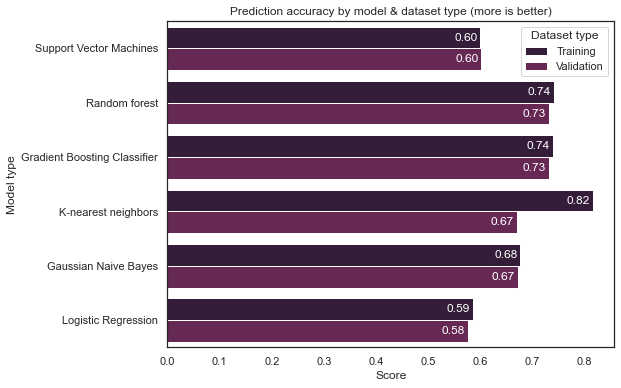

In [155]:
# using seaborn to compare model accuracy

# setting plot size :
sns.set_context("notebook")
# setting the palette : 
pal = sns.color_palette("rocket")

# creating the plot:
bar = sns.barplot(data = df
            ,x = 'Score'
            ,y = 'Model type'
            ,hue = 'Dataset type'
            ,ci = None
            ,orient = 'h'
            ,palette = pal
            )

# adding  value annotations to the bars :
for p in bar.patches:                         # for each bar:
    width = p.get_width()                     # get bar length
    bar.text(width-0.05,                      # set the text h pos
            p.get_y() + p.get_height() / 2,   
            '{:1.2f}'.format(width),          # set variable to display, 2 decimals
            ha = 'left',                      # horizontal alignment
            va = 'center',                    # vertical alignment
            color = 'white')                  # text color

bar.set_title("Prediction accuracy by model & dataset type (more is better)")

#### I chose to use a random forest classifier based on this data.  
# Fine-tuning model hyperparams with GridSearchCV:

In [201]:
from sklearn.model_selection import GridSearchCV
# i.e. on va pimper le random forest sa mère

classif = RandomForestClassifier(n_estimators=250)
# read the docs to create this abomination :
param_l = {
    "criterion": ["gini", "entropy"],
    "max_depth": [ 5, 7, 9, 12, 15, 20],
    "min_samples_split": [2, 5, 10, 15, 100],
    "min_samples_leaf": [2, 5, 7, 9, 12, 15, 20, 500],
    "max_features": ['auto', 'sqrt', 0.5, 0.4, 0.3] }

cv_searcher = GridSearchCV(classif,
                        param_l,
                        cv=5,
                        verbose=2,
                        pre_dispatch='4*n_jobs',
                        n_jobs=-1)

cv_searcher.fit(train_x, train_y) 


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=250),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9, 12, 15, 20],
                         'max_features': ['auto', 'sqrt', 0.5, 0.4, 0.3],
                         'min_samples_leaf': [2, 5, 7, 9, 12, 15, 20, 500],
                         'min_samples_split': [2, 5, 10, 15, 100]},
             pre_dispatch='4*n_jobs', verbose=2)

In [202]:
#save the GridSearchCV results as soon as it is finished:
import pickle as pk
with open("./cv_searcher.pk", "wb") as fp:
    pk.dump(cv_searcher, fp)

In [203]:
# display the best results:
cv_searcher.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2}

0.7552379169007345


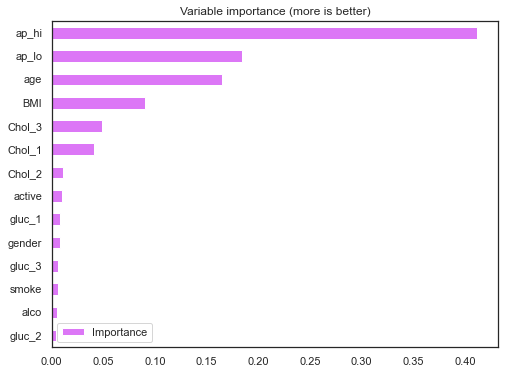

In [212]:
plot_model_var_imp(rand_for, train_x , train_y)

In [209]:
from sklearn.model_selection import GridSearchCV


# no need to fine-tune n_estimators and n_jobs
rand_for = RandomForestClassifier(n_estimators=500,
                                  max_depth = 12,      #advice says btwn 5-15 to reduce overfitting
                                  min_samples_leaf=5,
                                  min_samples_split =2,
                                  max_features='auto',
                                  criterion='entropy',
                                  n_jobs=-1
                                 )

rand_for.fit(train_x , train_y)

print(f"""
Training accuracy: {round(rand_for.score( train_x , train_y ),4)}     
Validation accuracy: {round(rand_for.score( valid_x , valid_y ),4)}    
""")


Training accuracy: 0.7552     
Validation accuracy: 0.73    



# Model crossvalidation :

In [ ]:
from sklearn.model_selection import cross_val_score

# model cross validation :
scores = cross_val_score(rfc, X_train, y_train, cv=10)
print(scores.mean()*100, scores.min()*100, scores.max()*100)
# model testing :
Y_hat = rfc.predict(X_test)
print(classification_report(y_test, Y_hat))